In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<h2>Data Preprocessing

In [48]:
data = pd.read_csv('Data_Melbourne_F_fixed.csv')
print(data.head())
print(data.info())

   Serial No  Average Outflow  Average Inflow  Energy Consumption  Ammonia  \
0          0            2.941           2.589              175856     27.0   
1          1            2.936           2.961              181624     25.0   
2          2            2.928           3.225              202016     42.0   
3          3            2.928           3.354              207547     36.0   
4          4            2.917           3.794              202824     46.0   

   Biological Oxygen Demand  Chemical Oxygen Demand  Total Nitrogen  \
0                     365.0                   730.0          60.378   
1                     370.0                   740.0          60.026   
2                     418.0                   836.0          64.522   
3                     430.0                   850.0          63.000   
4                     508.0                  1016.0          65.590   

   Average Temperature  Maximum temperature  Minimum temperature  \
0                 19.3              

Missing Values:
 Serial No                   0
Average Outflow             0
Average Inflow              0
Energy Consumption          0
Ammonia                     0
Biological Oxygen Demand    0
Chemical Oxygen Demand      0
Total Nitrogen              0
Average Temperature         0
Maximum temperature         0
Minimum temperature         0
Atmospheric pressure        0
Average humidity            0
Total rainfall              0
Average visibility          0
Average wind speed          0
Maximum wind speed          0
Year                        0
Month                       0
Day                         0
dtype: int64


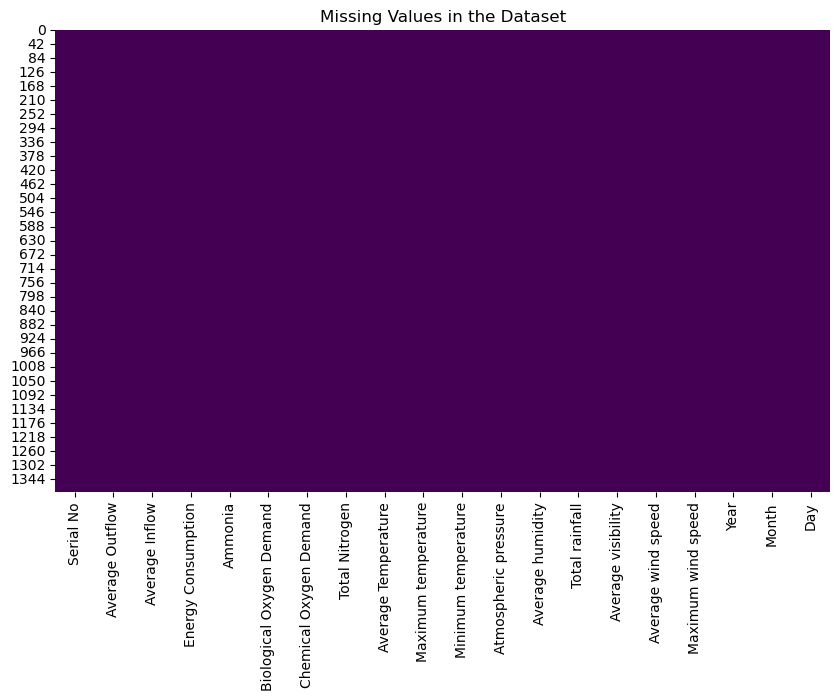

In [49]:
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

#Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in the Dataset")
plt.show()

In [50]:
#mean imputation for numerical features
imputer = SimpleImputer(strategy="mean")
data.iloc[:, 1:] = imputer.fit_transform(data.iloc[:, 1:])  #Skip 'Serial No'

#Confirming is there any missing values remaining
print(data.isnull().sum().sum(), "Missing values remaining.")

0 Missing values remaining.


**Feature Scaling**

In [51]:
#Standardizing the dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, 1:])  #Skip 'Serial No'

#Converting back to DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=data.columns[1:])
data_scaled.insert(0, 'Serial No', data['Serial No'])

**Visualization of scaled features**

In [52]:
print(data.columns)

Index(['Serial No', 'Average Outflow', 'Average Inflow', 'Energy Consumption',
       'Ammonia', 'Biological Oxygen Demand', 'Chemical Oxygen Demand',
       'Total Nitrogen', 'Average Temperature', 'Maximum temperature',
       'Minimum temperature', 'Atmospheric pressure', 'Average humidity',
       'Total rainfall', 'Average visibility', 'Average wind speed',
       'Maximum wind speed', 'Year', 'Month', 'Day'],
      dtype='object')


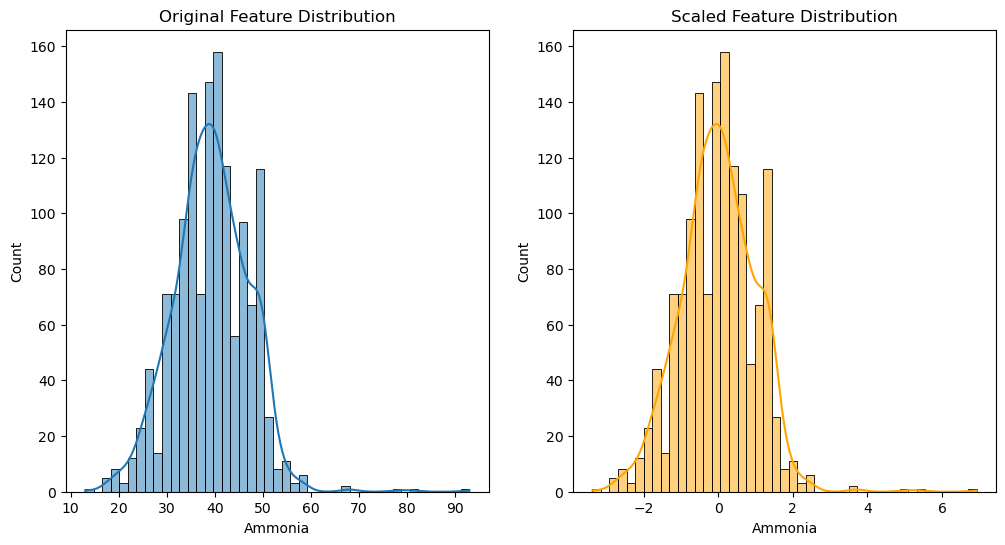

In [53]:
#Plotting the distribution of a few features before and after scaling
original_feature = data['Ammonia']  
scaled_feature = data_scaled['Ammonia']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(original_feature, kde=True)
plt.title("Original Feature Distribution")

plt.subplot(1, 2, 2)
sns.histplot(scaled_feature, kde=True, color='orange')
plt.title("Scaled Feature Distribution")
plt.show()

**Correlation Matrix**

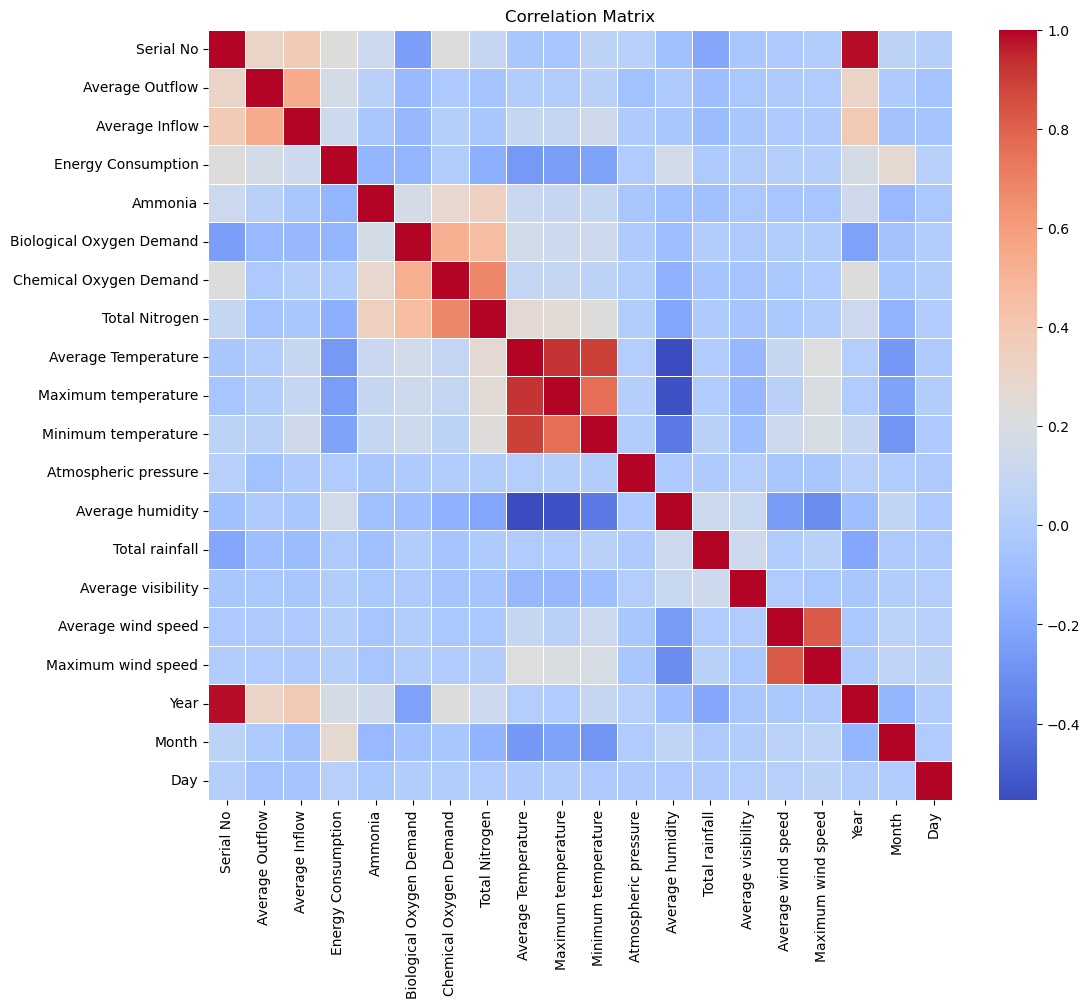

In [54]:
corr_matrix = data_scaled.corr()

#Visualization of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Feature Selection**

In [55]:
#Removing features with constant values
X = X.loc[:, X.apply(pd.Series.nunique) != 1]

In [56]:
#Check for NaN or infinite values
print(X.isna().sum())  #missing values
print((X == np.inf).sum())  #infinite values

Average Outflow        0
Average Inflow         0
Energy Consumption     0
Ammonia                0
Average Temperature    0
Maximum temperature    0
Minimum temperature    0
Average humidity       0
Year                   0
Month                  0
dtype: int64
Average Outflow        0
Average Inflow         0
Energy Consumption     0
Ammonia                0
Average Temperature    0
Maximum temperature    0
Minimum temperature    0
Average humidity       0
Year                   0
Month                  0
dtype: int64


In [57]:
#distribution of 'Energy Consumption' and 'Ammonia'
print(data[['Energy Consumption', 'Ammonia']].describe())

       Energy Consumption      Ammonia
count         1382.000000  1382.000000
mean        275159.089001    39.222302
std          44640.533689     7.761598
min         116638.000000    13.000000
25%         246435.750000    34.000000
50%         275808.000000    39.000000
75%         305703.750000    44.000000
max         398328.000000    93.000000


In [59]:
#Creating a custom target column (example based on 'Energy Consumption' and 'Ammonia')
data['Operational State'] = np.where(
    (data['Energy Consumption'] < 300000) & (data['Ammonia'] < 50), 1, 0
)  #Thresholds for optimal operation

#features and target
X = data.drop(['Serial No', 'Operational State'], axis=1)  #Dropping the custom target column as well
y = data['Operational State']

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['Average Outflow', 'Average Inflow', 'Energy Consumption', 'Ammonia',
       'Average Temperature', 'Maximum temperature', 'Minimum temperature',
       'Average humidity', 'Year', 'Month'],
      dtype='object')


In [60]:
#Adding the 'Operational State' to the scaled dataset
data_scaled['Operational State'] = data['Operational State']

#final dataset with selected features and 'Operational State'
final_data = data_scaled[['Serial No'] + list(selected_features) + ['Operational State']]

#Printing the first few rows of the final dataset
print(final_data.head())

   Serial No  Average Outflow  Average Inflow  Energy Consumption   Ammonia  \
0          0        -0.805651       -1.332352           -2.225310 -1.575285   
1          1        -0.809721       -1.073851           -2.096054 -1.833057   
2          2        -0.816234       -0.890398           -1.639084  0.358007   
3          3        -0.816234       -0.800756           -1.515138 -0.415310   
4          4        -0.825189       -0.495001           -1.620977  0.873551   

   Average Temperature  Maximum temperature  Minimum temperature  \
0             0.790009             0.644062             0.550494   
1             0.382340             0.432622             0.486050   
2             0.326749             0.940079            -0.265797   
3            -0.080920            -0.088932             0.228274   
4            -0.303284            -0.201700            -0.437647   

   Average humidity      Year     Month  Operational State  
0         -0.520245 -1.426683 -1.520674                

<h2>Modeling with Machine Learning Algorithms:

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#Train-test split
X = final_data.drop(['Serial No', 'Operational State'], axis=1)  #Features
y = final_data['Operational State']  #Target

#Splitting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Applying SMOTE to balance the class distribution in training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#new class distribution
print("Class distribution after SMOTE:\n", y_train_resampled.value_counts())

#Model Training and Evaluation
#Logistic Regression 
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        self.theta = np.zeros(X.shape[1])
        for _ in range(self.n_iterations):
            predictions = self.sigmoid(np.dot(X, self.theta))
            gradients = np.dot(X.T, predictions - y) / y.size
            self.theta -= self.learning_rate * gradients
    
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.theta)) >= 0.5

#Logistic Regression from scratch
lr_scratch = LogisticRegressionScratch(learning_rate=0.1, n_iterations=1000)
lr_scratch.fit(X_train.values, y_train.values)
y_pred_lr_scratch = lr_scratch.predict(X_test.values)

#Evaluation of Logistic Regression from scratch
print("Logistic Regression (Scratch) Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_scratch))
print("F1 Score:", f1_score(y_test, y_pred_lr_scratch))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_scratch))

#Logistic Regression using sklearn
lr_sklearn = LogisticRegression(class_weight='balanced')
lr_sklearn.fit(X_train, y_train)
y_pred_lr_sklearn = lr_sklearn.predict(X_test)

#Evaluation of Logistic Regression (sklearn)
print("\nLogistic Regression (sklearn) Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_sklearn))
print("F1 Score:", f1_score(y_test, y_pred_lr_sklearn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_sklearn))

#K-Nearest Neighbors(KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

#Evaluation of KNN
print("\nK-Nearest Neighbors Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

#Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

#Evaluation of Decision Tree Classifier
print("\nDecision Tree Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

#Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#Evaluation of Random Forest Classifier
print("\nRandom Forest Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

#Support Vector Machine (SVM)
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

#Evaluation of SVM
print("\nSupport Vector Machine (SVM) Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

Class distribution after SMOTE:
 Operational State
0    693
1    693
Name: count, dtype: int64
Logistic Regression (Scratch) Evaluation:
Accuracy: 0.7870036101083032
F1 Score: 0.8078175895765471
Confusion Matrix:
 [[ 94  11]
 [ 48 124]]

Logistic Regression (sklearn) Evaluation:
Accuracy: 0.8267148014440433
F1 Score: 0.8571428571428572
Confusion Matrix:
 [[ 85  20]
 [ 28 144]]

K-Nearest Neighbors Evaluation:
Accuracy: 0.8483754512635379
F1 Score: 0.88268156424581
Confusion Matrix:
 [[ 77  28]
 [ 14 158]]

Decision Tree Classifier Evaluation:
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[105   0]
 [  0 172]]

Random Forest Classifier Evaluation:
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[105   0]
 [  0 172]]

Support Vector Machine (SVM) Evaluation:
Accuracy: 0.8989169675090253
F1 Score: 0.9213483146067417
Confusion Matrix:
 [[ 85  20]
 [  8 164]]


**Hyperparameter Tuning**

In [64]:
from sklearn.model_selection import GridSearchCV

#Parameter grids for hyperparameter tuning
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

#Function to evaluate models on the test set
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

#Logistic Regression with Grid Search
lr_grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid_lr, cv=5, n_jobs=-1, verbose=0)
lr_grid.fit(X_train, y_train)
print(f"Best Parameters for Logistic Regression: {lr_grid.best_params_}")
print(f"Best Cross-validation Score for Logistic Regression: {lr_grid.best_score_:.4f}")

#KNN with Grid Search
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, n_jobs=-1, verbose=0)
knn_grid.fit(X_train, y_train)
print(f"\nBest Parameters for K-Nearest Neighbors: {knn_grid.best_params_}")
print(f"Best Cross-validation Score for KNN: {knn_grid.best_score_:.4f}")

#Decision Tree with Grid Search
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, n_jobs=-1, verbose=0)
dt_grid.fit(X_train, y_train)
print(f"\nBest Parameters for Decision Tree: {dt_grid.best_params_}")
print(f"Best Cross-validation Score for Decision Tree: {dt_grid.best_score_:.4f}")

#Random Forest with Grid Search
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1, verbose=0)
rf_grid.fit(X_train, y_train)
print(f"\nBest Parameters for Random Forest: {rf_grid.best_params_}")
print(f"Best Cross-validation Score for Random Forest: {rf_grid.best_score_:.4f}")

#SVM with Grid Search
svm_grid = GridSearchCV(SVC(), param_grid_svm, cv=5, n_jobs=-1, verbose=0)
svm_grid.fit(X_train, y_train)
print(f"\nBest Parameters for SVM: {svm_grid.best_params_}")
print(f"Best Cross-validation Score for SVM: {svm_grid.best_score_:.4f}")

#Evaluation of the models on the test set with the best parameters
print("\nFinal evaluation on test data:")
evaluate_model(lr_grid, X_test, y_test, "Logistic Regression")
evaluate_model(knn_grid, X_test, y_test, "K-Nearest Neighbors")
evaluate_model(dt_grid, X_test, y_test, "Decision Tree")
evaluate_model(rf_grid, X_test, y_test, "Random Forest")
evaluate_model(svm_grid, X_test, y_test, "Support Vector Machine (SVM)")

Best Parameters for Logistic Regression: {'C': 0.1, 'max_iter': 100, 'solver': 'saga'}
Best Cross-validation Score for Logistic Regression: 0.8525

Best Parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Cross-validation Score for KNN: 0.8751

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-validation Score for Decision Tree: 1.0000

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-validation Score for Random Forest: 0.9991

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Score for SVM: 0.9267

Final evaluation on test data:

Logistic Regression - Accuracy: 0.8303
F1 Score: 0.8597
Confusion Matrix:
[[ 86  19]
 [ 28 144]]

K-Nearest Neighbors - Accuracy: 0.8412
F1 Score: 0.8771
Confusion Matrix:
[[ 76  29]
 [ 15 157]]

Decision Tree - Accuracy: